In [2]:
import os, random, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import dask
from dask.diagnostics import ProgressBar
import caiman as cm
import h5py
# from skimage.external import tifffile as tff
from sklearn.decomposition import PCA
import tifffile as tff
import joblib
import plotly.graph_objects as go
import glob
import seaborn as sns

codeDir = r'V:/code/python/code'
sys.path.append(codeDir)
import apCode.FileTools as ft
import apCode.volTools as volt
from apCode.machineLearning import ml as mlearn
import apCode.behavior.FreeSwimBehavior as fsb
import apCode.behavior.headFixed as hf
import apCode.SignalProcessingTools as spt
import apCode.geom as geom
import importlib
from apCode import util as util
from apCode import hdf
from apCode.imageAnalysis.spim import regress
from apCode.behavior import gmm as my_gmm
from apCode.machineLearning.preprocessing import Scaler
import rsNeuronsProj.util as rsp

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


try:
    if __IPYTHON__:
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

# Setting seed for reproducability
seed = 143
random.seed = seed

print(time.ctime())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mon May  4 12:42:29 2020


### *Read the xls sheet with all the data paths*

In [3]:
#%% Path to excel sheet storing paths to data and other relevant info
dir_xls = r'Y:\Avinash\Projects\RS recruitment\GCaMP imaging'
file_xls = 'GCaMP volumetric imaging summary.xlsx'
xls = pd.read_excel(os.path.join(dir_xls, file_xls), sheet_name='Sheet1')
xls.head()

,Date,Genotype,Session,Time,FishIdx,FishIdxInSession,Path,RoiSet,AllCaImgs,Quality,Comments
0,20191106.0,xa316,0,2300,0,0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,1,Poor SNR
1,20191107.0,xa316,0,2200,1,0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN
2,20191119.0,xa316,0,2200,2,1,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN
3,20191207.0,nefma-alx,0,2400,3,2,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN
4,20191211.0,xa316,0,1800,4,1,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...,0,0.0,?,NaN


### *Filter dataframe to keep good ones*

In [258]:
xls_sub = xls.loc[xls.RoiSet==1]
print(xls_sub.shape)

(5, 11)


### *Read roi_ts dataframes*

In [420]:
dataFrame = []
for iPath, path_ in enumerate(xls_sub.Path):
    pp = glob.glob(os.path.join(path_, 'roi_ts*.pkl'))
    if len(pp)==0:
        print(f'Dataframe not found in {path_}')
    else:
        df_ = pd.read_pickle(pp[-1])
        df_ = df_.assign(fishIdx=iPath, path=pp[0])
        dataFrame.append(df_)
dataFrame = pd.concat(dataFrame, axis=0, ignore_index=True)
dataFrame.head()

,roiName,stimLoc,ca,fishIdx,path
0,L.Mauthner,h,"[0.0023328145345051787, 0.0, 0.000545247395833...",0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...
1,L.Mauthner,h,"[-0.00040842692057291297, 0.0, 0.0024291992187...",0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...
2,L.Mauthner,h,"[0.0012026468912759714, 0.0, 0.000891621907552...",0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...
3,L.Mauthner,h,"[0.0006144205729166075, 0.0, -0.00073496500651...",0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...
4,L.Mauthner,h,"[0.001739247639973962, 0.0, 0.0007413228352864...",0,Y:\Avinash\Head-fixed tail free\GCaMP imaging\...


In [421]:
#%% Fix naming errors
roiNames_all = np.array(dataFrame.roiName)
roiNames_all = [_.replace('RoV2', 'RoV3') for _ in roiNames_all]
roiNames_all = [_.replace('Rov3', 'RoV3') for _ in roiNames_all]
roiNames_all = [_.replace('Rom2', 'RoM2') for _ in roiNames_all]

# inds = util.findStrInList('RoV2', roiNames_all)
# rn_now = [_.replace('RoV2', 'Rov3') for _ in roiNames_all[inds]]
# roiNames_all[inds] = rn_now
dataFrame = dataFrame.assign(roiName=roiNames_all)

### _Plot_

### _First plot trial averaged Ca2+ responses across oll fish_

In [509]:
nPre = 3
sf = 5000
roiNames_all = np.array(dataFrame.roiName)
roiNames_core = np.array([_.split('.')[1] for _ in np.unique(roiNames_all)])
roiNames_core = np.unique(roiNames_core)
roiNames_core = roiNames_core[rsp.bing.omitRois(roiNames_core, ['LL'])]
roi_dict = dict(mu=[], sem=[], name=[], stim=[], peak=[])
for rn in roiNames_core:
    for side in ['L', 'R']:
        for stim in ['h', 't']:
            rn_now = f'{side}.{rn}'    
            inds = util.findStrInList(rn_now, roiNames_all)
            if len(inds)==0:
                print(f'No roi by that name: {rn_now}')
            else:
                df_sub = dataFrame.iloc[inds]
                ca_ = np.array([np.array(_) for _ in df_sub.loc[df_sub.stimLoc==stim].ca])
                f0 = np.median(ca_[:,:nPre], axis=1)[:, None]
                ca_ = ca_-f0
                mu = ca_.mean(axis=0)
                sem = mu/np.sqrt(ca_.shape[0])
                pks = np.round((ca_.max(axis=1)*sf)*100)/100
                roi_dict['mu'].append(mu)
                roi_dict['sem'].append(sem)
                roi_dict['name'].append(rn_now)
                roi_dict['stim'].append(stim)
                roi_dict['peak'].append(pks)
df_roi_mu = pd.DataFrame(roi_dict)
# print(np.unique(dataFrame.iloc[inds].path))


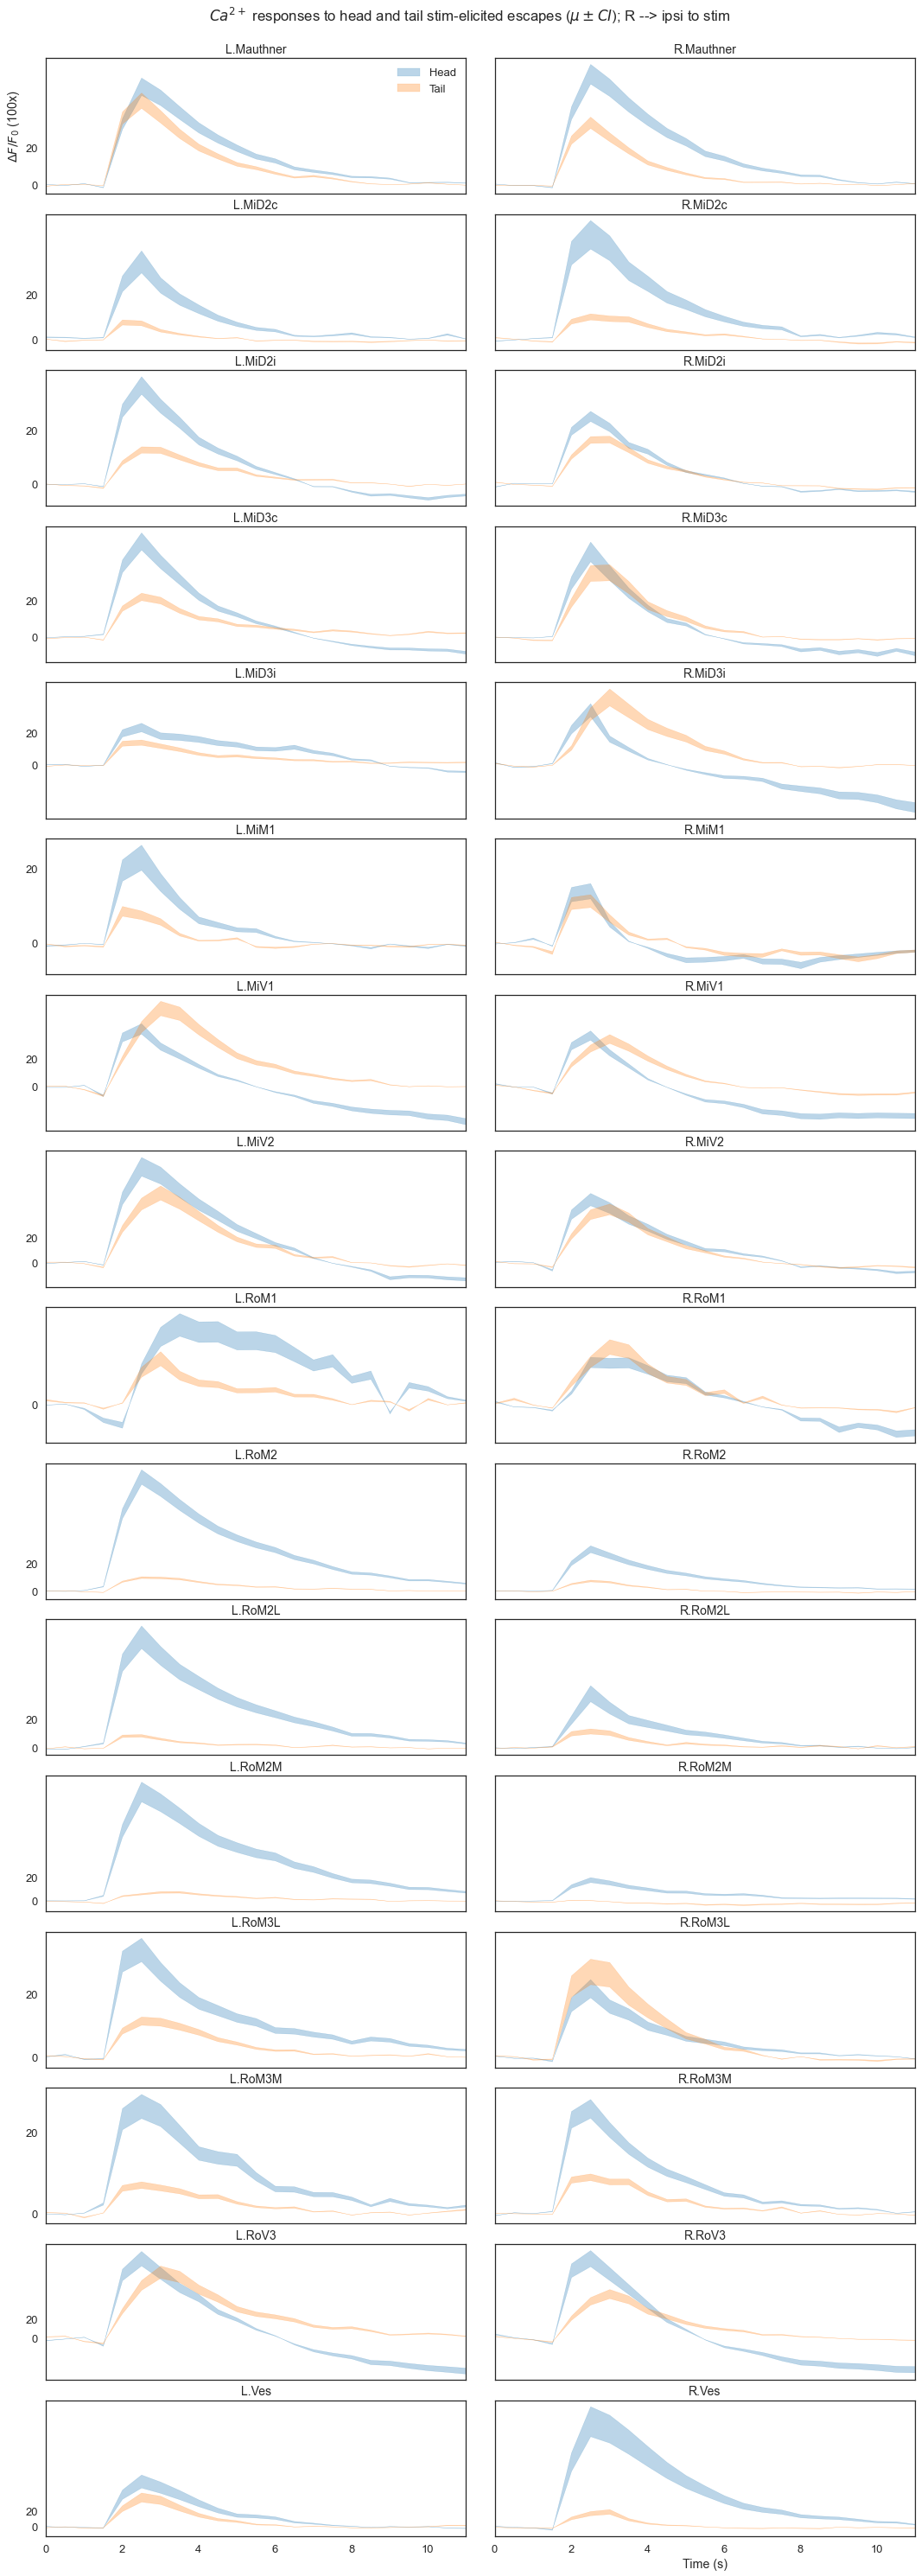

In [486]:
# nRows = int(df_roi_mu.shape[0]/2)
# nCols = 2
sz = 15
fh, ax = plt.subplots(nrows=nRows, ncols=nCols, figsize=(sz, int(0.35*sz*nRows/nCols)), sharex=True,
                      sharey='row')
fh.tight_layout()
for iRow, rn in enumerate(roiNames_core):
    for iSide, side in enumerate(["L", "R"]):        
        rn_now = f'{side}.{rn}'
        for iStim, stim in enumerate(['h', 't']):
            df_ = df_roi_mu.loc[(df_roi_mu.name==rn_now) & (df_roi_mu.stim==stim)]
            mu = np.array(df_['mu'])[0]*1000*5
            sem = np.array(df_['sem'])[0]*1000*5
            x = np.arange(len(mu))*(1/2)
            if (iRow==0) & (iSide==0):
                if stim=='h':
                    lbl = 'Head'
                else:
                    lbl = 'Tail'
                ax[iRow, iSide].fill_between(x, mu-sem, mu+sem, color=plt.cm.tab10(iStim),
                                             alpha=0.3, label=lbl)
                ax[iRow, iSide].legend(loc='best')
                ax[iRow, iSide].set_ylabel('$\Delta F/F_0$ (100x)')
            else:                
                ax[iRow, iSide].fill_between(x, mu-sem, mu+sem, color=plt.cm.tab10(iStim), alpha=0.3)
            ax[iRow, iSide].set_yticks([0, 20])
            ax[iRow, iSide].set_title(rn_now, fontsize=14)            
ax[iRow, iSide].set_xlim(x[0], x[-1])
ax[iRow, iSide].set_xlabel('Time (s)')
fh.suptitle('$Ca^{2+}$ responses to head and tail stim-elicited escapes ($\mu \pm CI$); R --> ipsi to stim')
fh.subplots_adjust(hspace=0.15, top=0.96)
        

### *Save the figure*

In [487]:
figDir = r'Y:\Avinash\Projects\RS recruitment\Figures'
saveDir = os.path.join(figDir, util.timestamp())
if not os.path.exists(saveDir):
    os.mkdir(saveDir)
fn = f'Fig-{util.timestamp()}_Ca responses in response to head- and tail stim-elicited escapes'
fh.savefig(os.path.join(saveDir, fn + '.pdf'))
fh.savefig(os.path.join(saveDir, fn + '.png'))

### _Plot peak Ca2+ responses as factor plot_

In [602]:
#%% Create a new dataframe suitable for categorical/factor plot
nPre = 3
sf = 2500
roiNames_all = np.array(dataFrame.roiName)
roiNames_core = np.array([_.split('.')[1] for _ in np.unique(roiNames_all)])
roiNames_core = np.unique(roiNames_core)
roiNames_core = roiNames_core[rsp.bing.omitRois(roiNames_core, ['LL'])]
roi_dict = dict(ca_ts=[], roiName=[], stim=[], ca_pk=[], fishIdx=[], side=[], trlNum=[])
for rn in roiNames_core:
    for side in ['L', 'R']:
        for stim in ['h', 't']:
            rn_now = f'{side}.{rn}'    
            inds = util.findStrInList(rn_now, roiNames_all)
            if len(inds)==0:
                print(f'No roi by that name: {rn_now}')
            else:
                df_sub = dataFrame.iloc[inds]
                fishInds = np.unique(df_sub.fishIdx)
                for iFish, idx_fish in enumerate(fishInds):
                    df_fish = df_sub.loc[df_sub.fishIdx==idx_fish]
                    ca_ = np.array([np.array(_) for _ in df_sub.loc[df_sub.stimLoc==stim].ca])
                    f0 = np.median(ca_[:,:nPre], axis=1)[:, None]
                    ca_ = ca_-f0
                    pks = np.round((ca_.max(axis=1)*sf)*100)/100
                    nTrls = len(pks)
                    roi_dict['trlNum'].extend(np.arange(nTrls))
                    roi_dict['ca_ts'].extend(ca_)
                    roi_dict['roiName'].extend(np.array([rn]*nTrls))
                    roi_dict['stim'].extend(np.array([stim.upper()]*nTrls))
                    roi_dict['side'].extend(np.array([side.upper()]*nTrls))
                    roi_dict['fishIdx'].extend(np.array([idx_fish]*nTrls))
                    roi_dict['ca_pk'].extend(pks)                    
dataFrame_max = pd.DataFrame(roi_dict)
# print(np.unique(dataFrame.iloc[inds].path))


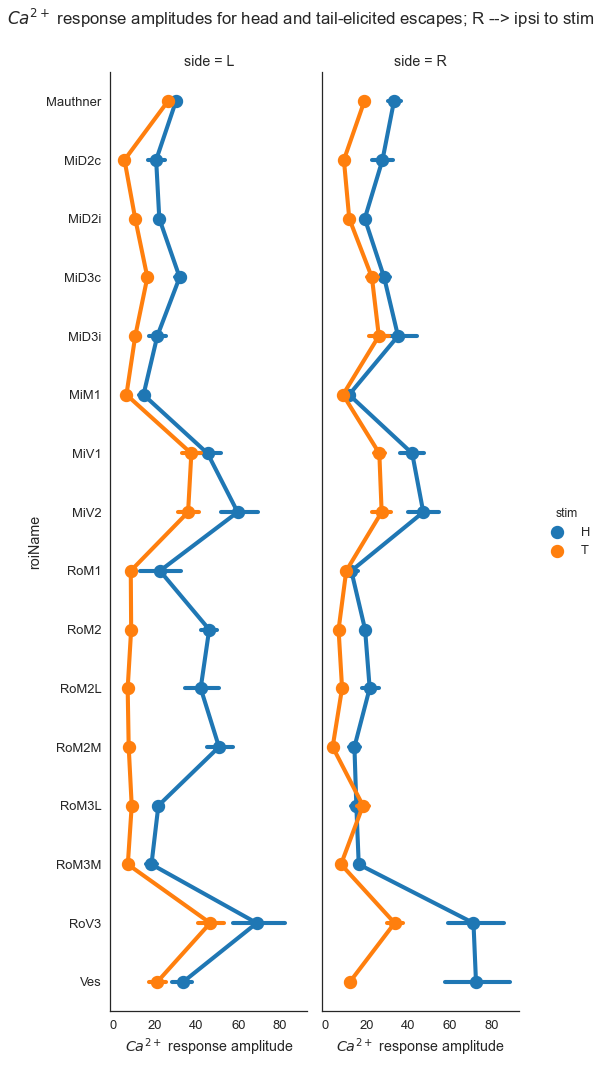

In [628]:
g = sns.catplot(data=dataFrame_max, y='roiName', x='ca_pk', kind='point', hue='stim', 
                col='side', aspect=0.25, height=15, margin_titles=True, ci=99, palette='tab10', sharex=True)
g.fig.suptitle("$Ca^{2+}$ response amplitudes for head and tail-elicited escapes; R --> ipsi to stim")
g.fig.subplots_adjust(top=0.92)
g.set_xlabels('$Ca^{2+}$ response amplitude')
fn = f'Fig-{util.timestamp()} Ca response amplitudes for head and tail-elicited stimuli'
g.savefig(os.path.join(saveDir, fn + '.pdf'), dpi='figure')
g.savefig(os.path.join(saveDir, fn + '.png'), dpi='figure')

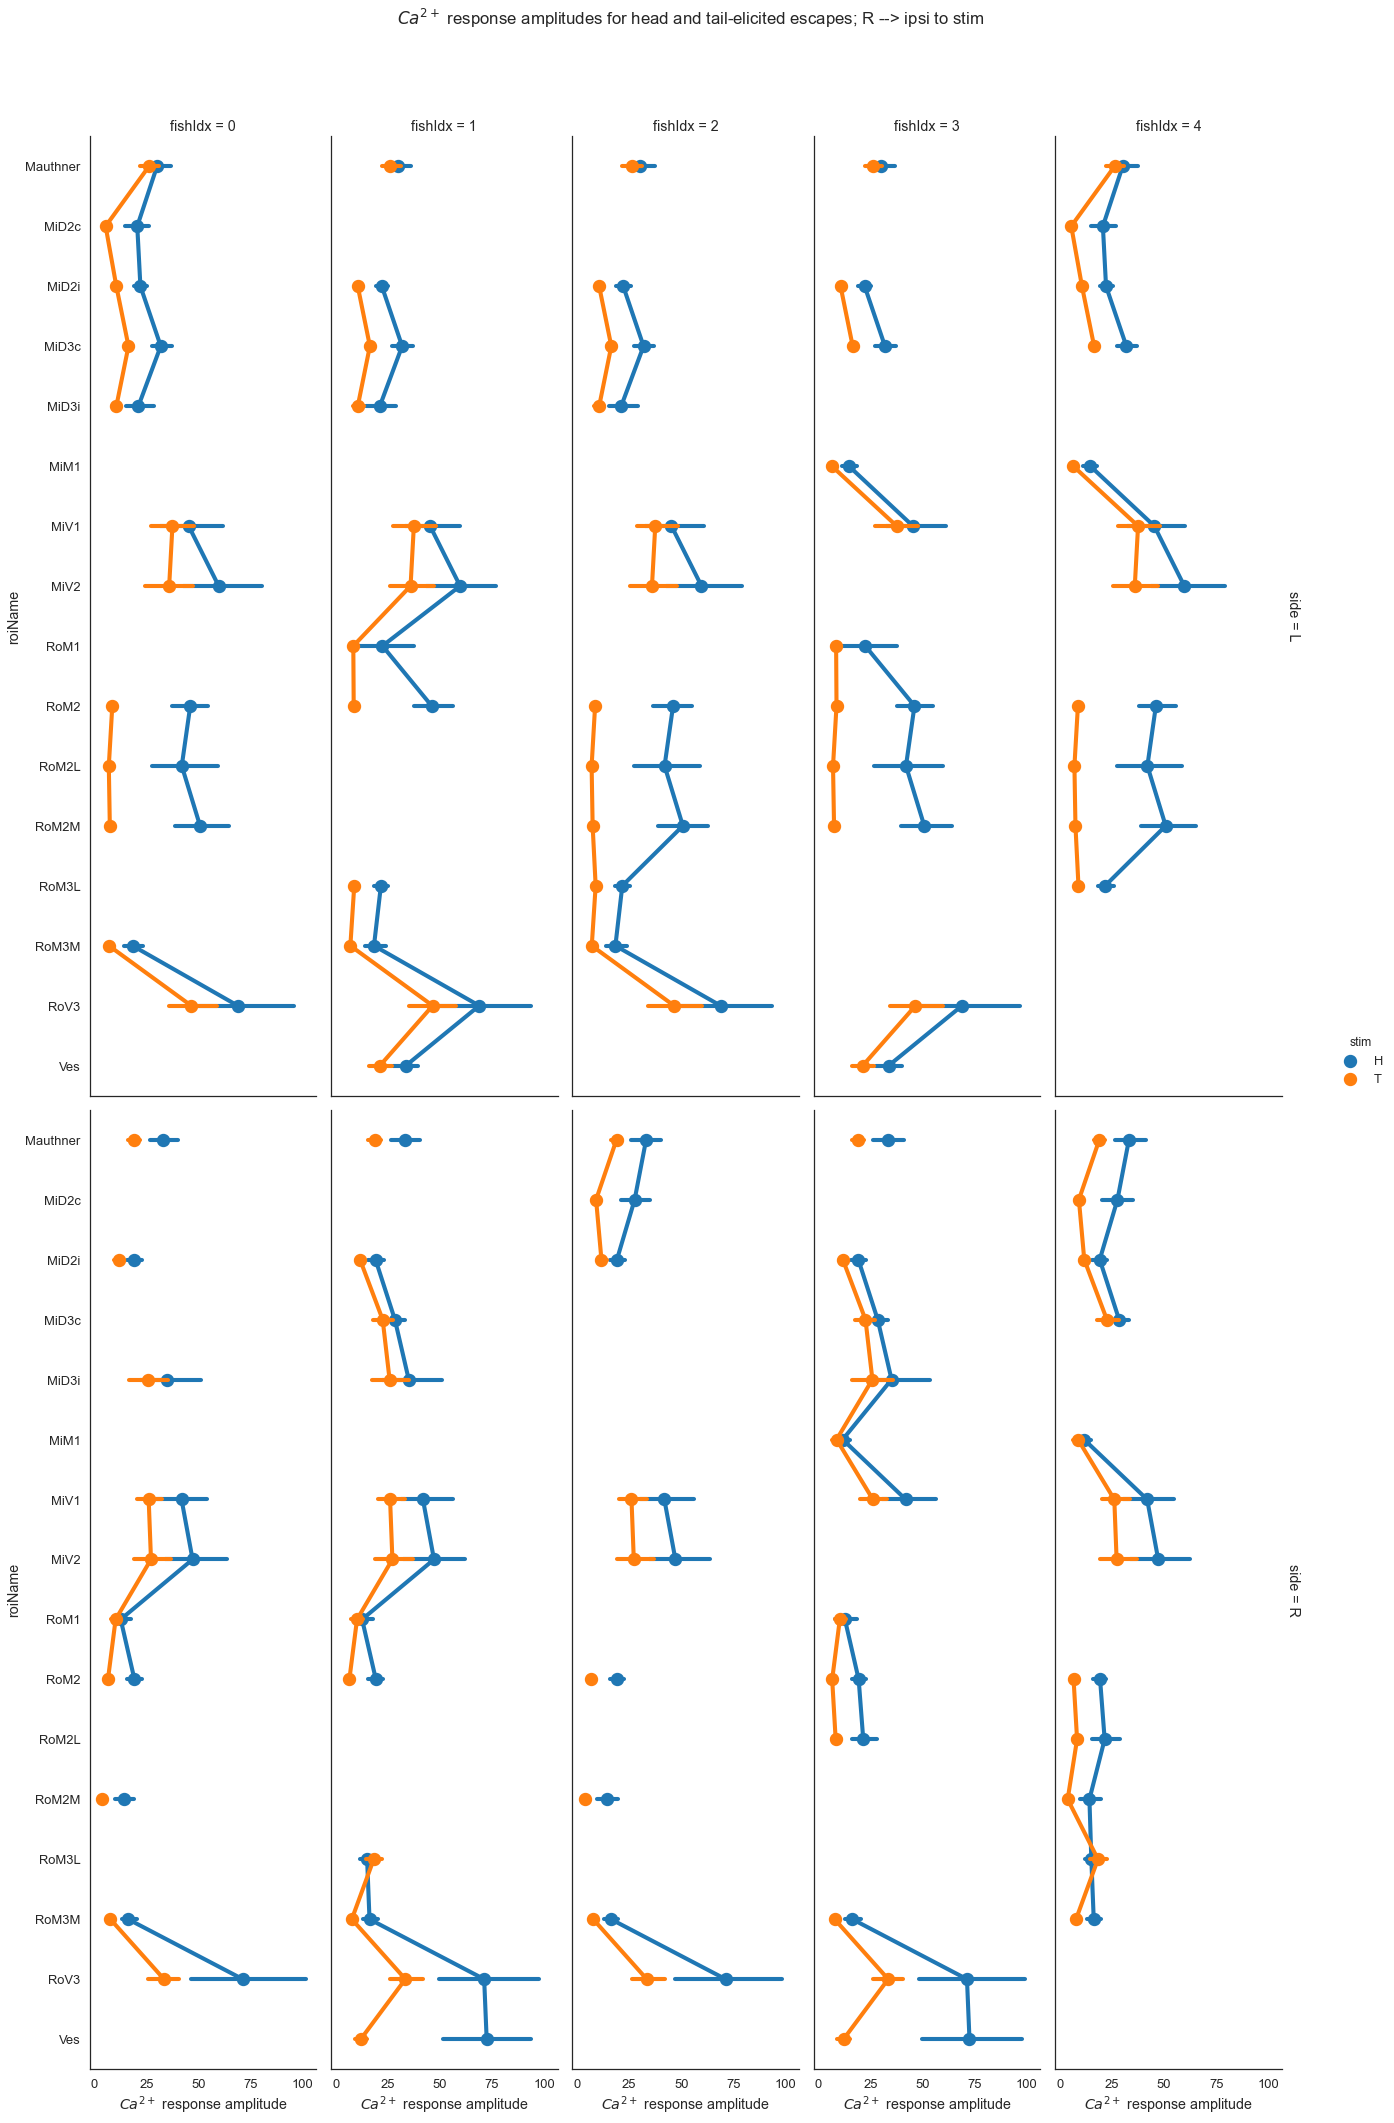

In [630]:
g = sns.catplot(data=dataFrame_max, y='roiName', x='ca_pk', kind='point', hue='stim', 
                col='fishIdx', aspect=0.25, height=15, margin_titles=True, ci=99,
                palette='tab10', sharex=True, row='side')
g.fig.suptitle("$Ca^{2+}$ response amplitudes for head and tail-elicited escapes; R --> ipsi to stim")
g.fig.subplots_adjust(top=0.92)
g.set_xlabels('$Ca^{2+}$ response amplitude')
fn = f'Fig-{util.timestamp()} Ca response amplitudes for head and tail-elicited stimuli'
# g.savefig(os.path.join(saveDir, fn + '.pdf'), dpi='figure')
# g.savefig(os.path.join(saveDir, fn + '.png'), dpi='figure')

### *Behavior variability*

In [694]:
#%% A function for extracting behavior and stim location from paths and putting in dataframe
def get_behav_from_path(path, fishLen=50):
    path_hFile = glob.glob(os.path.join(path, 'procData*.h5'))
    if len(path_hFile)>0:
        path_hFile = path_hFile[-1]
    else:
        print(f'No HDF file in path:\t {path}')
        return None
    with h5py.File(path_hFile, mode='r') as hFile:
        if 'behav' in hFile:
            grp = hFile['behav']
            if ('tailAngles' in grp) & ('stimLoc' in grp):
                ta = np.array(grp['tailAngles'])
                nTrls = ta.shape[0]//fishLen
                ta = ta[:nTrls*fishLen].reshape(nTrls, fishLen,-1)
                stimLoc = util.to_utf(grp['stimLoc'])
                trlNum = np.arange(nTrls)
                dic = dict(trlNum=trlNum, tailAngles=list(ta), stim=stimLoc, path=[path_hFile]*nTrls)
            else:
                dic = None
        else:
            dic=None
    if dic is not None:
        dic = pd.DataFrame(dic)
    return dic

### _Extract tail angles from all datasets where behavior's been extracted already_

In [697]:
fishInds = np.unique(xls.FishIdx)
dataFrame_behav = []
for iFish, idx_fish in enumerate(fishInds):
    print(f'Fish # {iFish}/{len(fishInds)}')
    path_ = xls.loc[xls.FishIdx==idx_fish].Path.iloc[0]
    df_ = get_behav_from_path(path_)
    if df_ is not None:
        df_ = df_.assign(fishIdx=idx_fish)
        dataFrame_behav.append(df_)
dataFrame_behav = pd.concat(dataFrame_behav, axis=0, ignore_index=True)

Fish # 0/13
Fish # 1/13
Fish # 2/13
No HDF file in path:	 Y:\Avinash\Head-fixed tail free\GCaMP imaging\2019-11-19\f2
Fish # 3/13
Fish # 4/13
Fish # 5/13
Fish # 6/13
Fish # 7/13
Fish # 8/13
Fish # 9/13
Fish # 10/13
Fish # 11/13
Fish # 12/13


### _Clean tail angles using SVD_

In [716]:
#%% Clean tail angles using SVD
trlLens = np.array([_.shape[-1] for _ in ta])
trlLen = trlLens.min()
ta = np.array([np.array(_)[:,:trlLen] for _ in np.array(dataFrame_behav.tailAngles)])
nTrls = ta.shape[0]
ta_ser = np.concatenate(ta, axis=1)
# Clean tailAngles
%time ta_clean, _, svd = hf.cleanTailAngles(ta_ser)
ta_trl = np.array(np.hsplit(ta_clean, nTrls))
dataFrame_behav = dataFrame_behav.assign(tailAngles = list(ta_clean_trl))

Wall time: 47.7 s


### _Load pre-trained GM model and predict on all the behavrior trials_

In [7]:
#%% Load the trained model
import joblib
dir_group = r'\\Koyama-S2\Data3\Avinash\Projects\RS recruitment\GCaMP imaging\Group'
file_model = 'gmm_svd-3_env_pca-9_gmm-20_20200418-11.pkl' 
gmm_model = joblib.load(os.path.join(dir_group, file_model))

In [22]:
fsb.copy_images_for_training?

Signature:
fsb.copy_images_for_training(
    imgsOrPath,
    cropSize=None,
    savePath=None,
    nImgsToCopy=50,
    detect_motion_frames=True,
    **motion_kwargs,
)
Docstring:
Return probability images generated using the specified U net.
Parameters
----------
imgsOrPath: array, (nImgs, *imgDims)
    Images to train U net on
cropSize: 2-tuple, int or None
    Size to crop images to around the fish. A fish detection algorithm
    is used to detect fish that involves background subtraction, therefore,
    all the images must be from the same experiment and must contain a
    single fish at most
    If None, then does not crop images
savePath: None or str
    Path to directory where images are to be saved
detect_motion_frames: bool
    If True, then tries to detect frames capturing fish in motion
motion_kwargs: dict
    Keyword arguments for estimate_motion
Returns
-------
imgs_crop: array, (nImgsToCopy, *cropSize)
    Cropped images
File:      v:\code\python\code\apcode\behavior\free

NameError: name 'ta' is not defined

In [774]:
%%time
labels = []
for ta_ in ta_trl:
    lbls = gmm_model.predict(ta_)[0]
    labels.append(lbls)
dataFrame_behav = dataFrame_behav.assign(gmmLabels=labels)

Wall time: 6.03 s


In [851]:
lbls_of_interest = [18, 14, 1, 6, 11, 19, 15, 8]
lbl_names = ['Fast-large_struggle', 'Fast-large-escape', 'Medium slow',
             'Medium slow', 'Medium slow', 'Slow', 'Slow', 'Flicks']
tKer = 50e-3

labels=np.array(labels)
likelihood_swim = np.log2(np.abs(ta[:,-1,:]).mean(axis=0))
impulses_lbls = []
for lbl in lbls_of_interest:
    foo = np.zeros_like(labels)
    foo[np.where(labels==lbl)]=1
    impulses_lbls.append(foo)
impulses_lbls = np.array(impulses_lbls)
stimLoc = np.array(dataFrame_behav.stim)
trls_head = np.where(stimLoc=='h')[0]
trls_tail = np.where(stimLoc=='t')[0]

impulses_lbls_head = impulses_lbls[:, trls_head]
impulses_lbls_tail = impulses_lbls[:, trls_tail]
foo_head = impulses_lbls_head.sum(axis=1)
foo_tail = impulses_lbls_tail.sum(axis=1)
nKer = int(tKer*500)
P_head, P_tail = [], [] 
for lbl in foo_head:
    lbl_conv = spt.causalConvWithSemiGauss1d(lbl, nKer)
    P_head.append(lbl_conv)
    
for lbl in foo_tail:
    lbl_conv = spt.causalConvWithSemiGauss1d(lbl, nKer)
    P_tail.append(lbl_conv)

P_head, P_tail = np.array(P_head), np.array(P_tail)
tot = P_head.sum() + P_tail.sum()
P_head /= trls_head.shape[0]
P_tail /= trls_tail.shape[0]

(0.0, 3500.0)

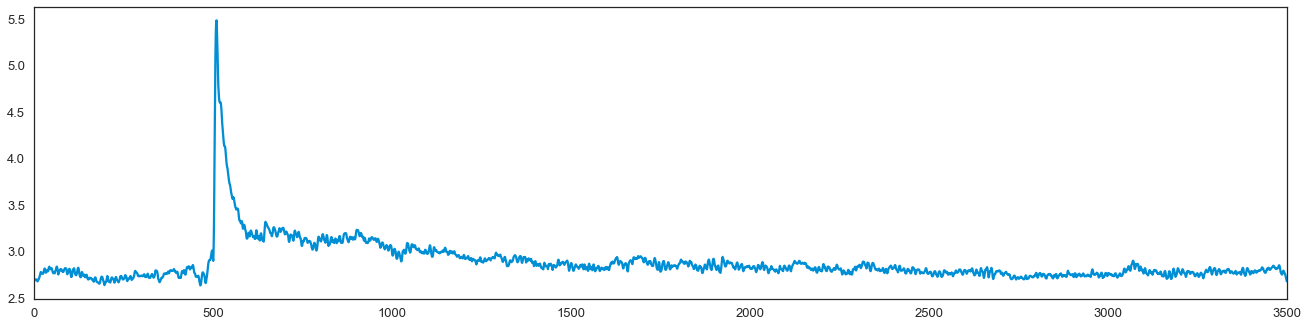

In [839]:
plt.figure(figsize=(20, 5))
plt.plot(likelihood_swim)
plt.xlim(0, len(likelihood_swim))

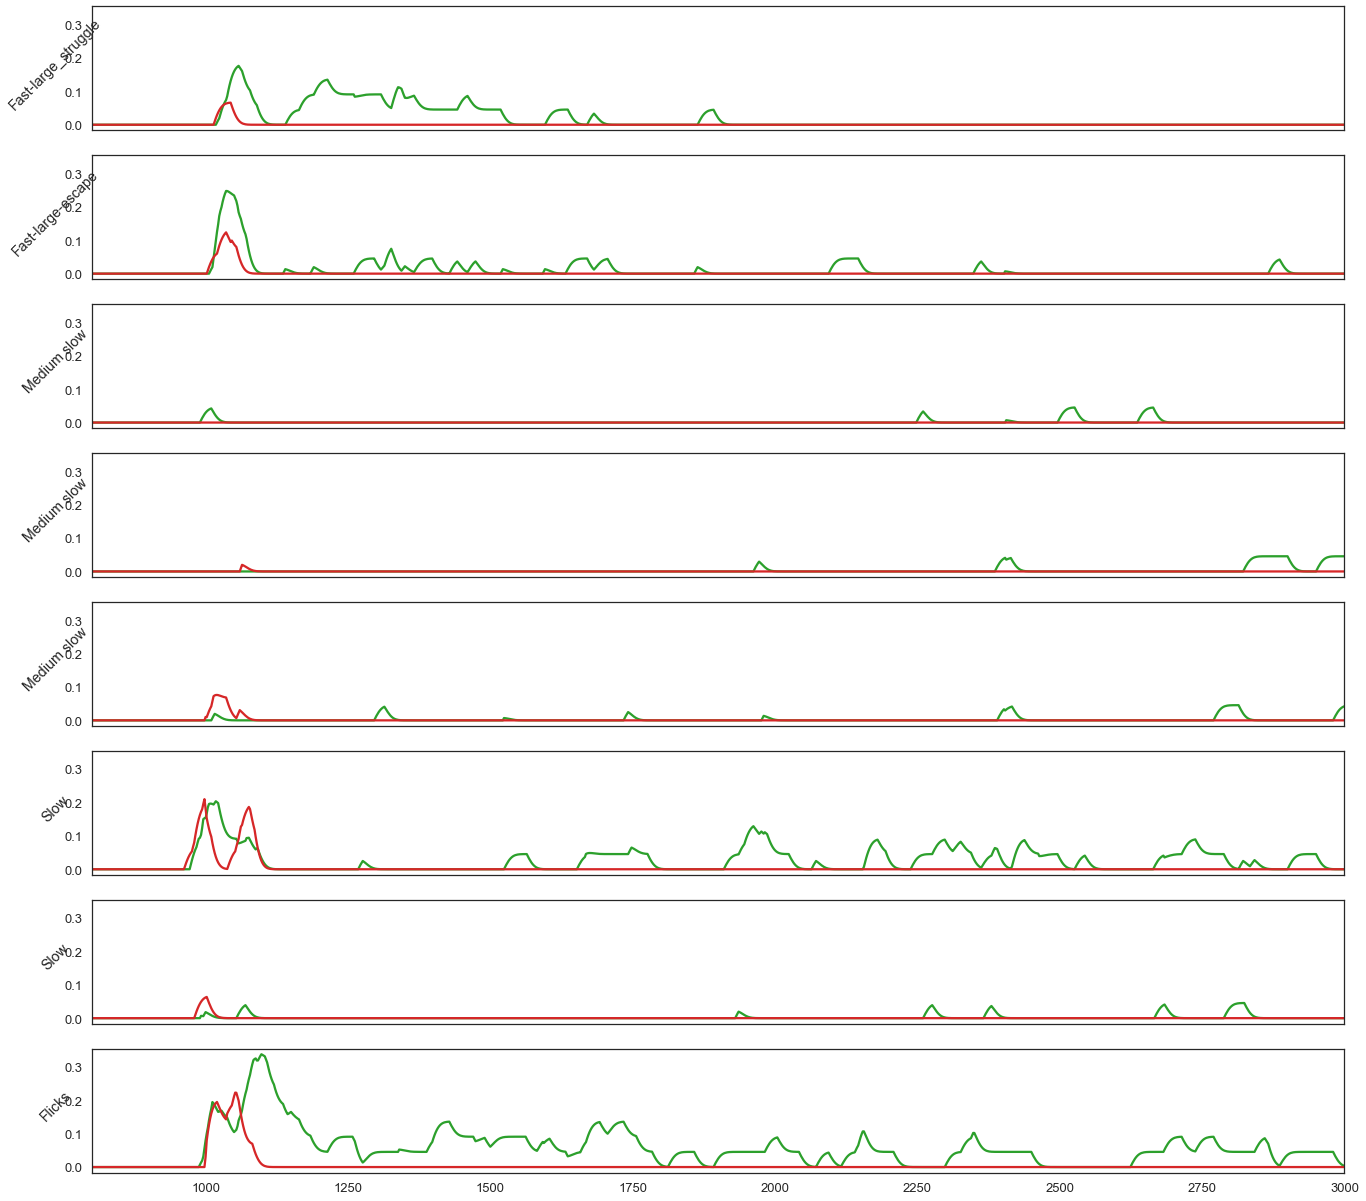

In [853]:
x = np.arange(P_head.shape[1])*(1/500)*1000
fh, ax = plt.subplots(P_head.shape[0],1, figsize=(20, 20), sharex=True, sharey=True)
count = 0
for head, tail in zip(P_head, P_tail):
#     ax[count].plot(x, np.log2(head+1e-6), c=plt.cm.tab10(0))
#     ax[count].plot(x, np.log2(tail+1e-6), c=plt.cm.tab10(1))
    ax[count].plot(x, head, c=plt.cm.tab10(2))
    ax[count].plot(x, tail, c=plt.cm.tab10(3))
#     ax[count].set_ylabel(f'Label # {lbls_of_interest[count]}')
    ax[count].set_ylabel(f'{lbl_names[count]}', rotation=45)
    count +=1
ax[count-1].set_xlim(800, 3000);